# DPD Test - April 14th 2022

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from monk import nb

from typing import Callable, Optional

import hoomd
import gsd.hoomd

from monk import prep

import ex_render

In [41]:
seed = 124
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device, seed=seed)

In [28]:
r_l = 5.0

N = 4096
rng = prep.init_rng(seed + 1)
snap = prep.approx_euclidean_snapshot(N, 400, rng, ratios=[1,99], diams=[r_l, 1.0])

sim.create_state_from_snapshot(snap)
sim.always_compute_pressure = True

In [42]:
sim.create_state_from_gsd("starting-point.gsd")

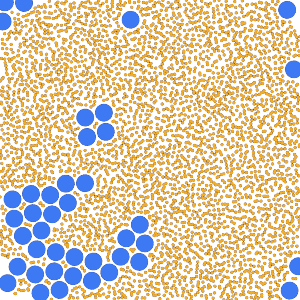

In [43]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [44]:
integrator = hoomd.md.Integrator(dt=0.005)
tree = hoomd.md.nlist.Tree(0.3)
dlvo = hoomd.md.pair.DLVO(tree)
dlvo.params[('A', 'A')] = dict(A=100.0, kappa=1.0, Z=0, a1=r_l/2, a2=r_l/2)
dlvo.r_cut[('A', 'A')] = 25.0
dlvo.params[('A', 'B')] = dict(A=0.0, kappa=1.0, Z=0, a1=r_l/2, a2=0.5)
dlvo.r_cut[('A', 'B')] = 0.0
dlvo.params[('B', 'B')] = dict(A=0.0, kappa=1.0, Z=0, a1=0.5, a2=0.5)
dlvo.r_cut[('B', 'B')] = 0.0
dpd = hoomd.md.pair.DPD(tree, 1.5)
dpd.params[('A', 'A')] = dict(A=0.0, gamma=4.5)
dpd.r_cut[('A', 'A')] = 0.0
dpd.params[('A', 'B')] = dict(A=0.0, gamma=4.5)
dpd.r_cut[('A', 'B')] =  0.0
dpd.params[('B', 'B')] = dict(A=10.0, gamma=4.5)
dpd.r_cut[('B', 'B')] = 2.0
slj = hoomd.md.pair.ExpandedLJ(tree)
slj.params[('A', 'A')] = dict(epsilon=1e-6, sigma=1.0, delta=r_l)
slj.r_cut[('A', 'A')] = 2**(1/6) + r_l
slj.params[('A', 'B')] = dict(epsilon=1e-6, sigma=1.0, delta=r_l/2 + .5)
slj.r_cut[('A', 'B')] = 2**(1/6) + r_l/2 + .5
slj.params[('B', 'B')] = dict(epsilon=1.0, sigma=1.0, delta=0.0)
slj.r_cut[('B', 'B')] = 0.0
# dpd.params[(['A', 'B'], ['C', 'D'])] = dict(A=40.0, gamma=4.5)

nve = hoomd.md.methods.NVE(hoomd.filter.All())
integrator.forces = [dlvo, slj, dpd]
integrator.methods = [nve]

sim.operations.integrator = integrator


In [ ]:
sim.operations.computes.clear()
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)


variant = hoomd.variant.Ramp(0, 1, sim.timestep, t_ramp=10_000)

initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_rho = 0.6
final_box.volume = sim.state.N_particles / final_rho

resize_box = hoomd.update.BoxResize(hoomd.trigger.Periodic(10), sim.state.box, final_box, variant)

sim.operations.updaters.clear()
sim.operations.updaters.append(resize_box)


In [31]:
sim.run(110_000)

In [32]:
thermodynamic_properties.pressure

6.008171726906693

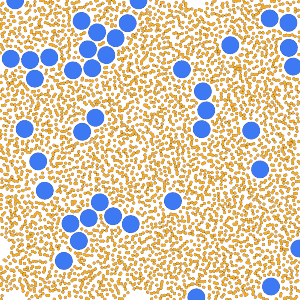

In [33]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [45]:
gsd_writer = hoomd.write.GSD(filename='traj7.gsd',
                             trigger=hoomd.trigger.Periodic(10_000),
                             mode='wb',
                             filter=hoomd.filter.All())
sim.operations.writers.clear()
sim.operations.writers.append(gsd_writer)
sim.run(1_000_000)

ex_render.display_movie(ex_render.render_disk_frame, "traj.gsd")

In [35]:
hoomd.write.GSD.write(sim.state, "starting-point.gsd")

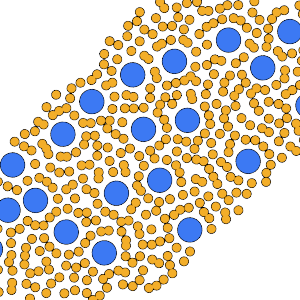

In [234]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [227]:
sim.run(90_000)

In [232]:
variant = hoomd.variant.Ramp(0, 1, sim.timestep, t_ramp=100_000)

initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box

final_box.xy = 1.0

resize_box = hoomd.update.BoxResize(hoomd.trigger.Periodic(10), sim.state.box, final_box, variant)

sim.operations.updaters.clear()
sim.operations.updaters.append(resize_box)

In [233]:
sim.run(100_000)